<a href="https://colab.research.google.com/github/truyen-deKy/LoRa/blob/main/QLoRa_avecVitesse_formuleDeThayChien.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
! cp /content/drive/MyDrive/plotting_edit.py /content

In [ ]:
import numpy as np
import gym
import operator
from itertools import combinations
import random
import matplotlib
import matplotlib.style
import sys
from collections import defaultdict
import plotting_edit
from scipy.stats import nakagami  
import scipy.special
 
matplotlib.style.use('ggplot')

# New Section

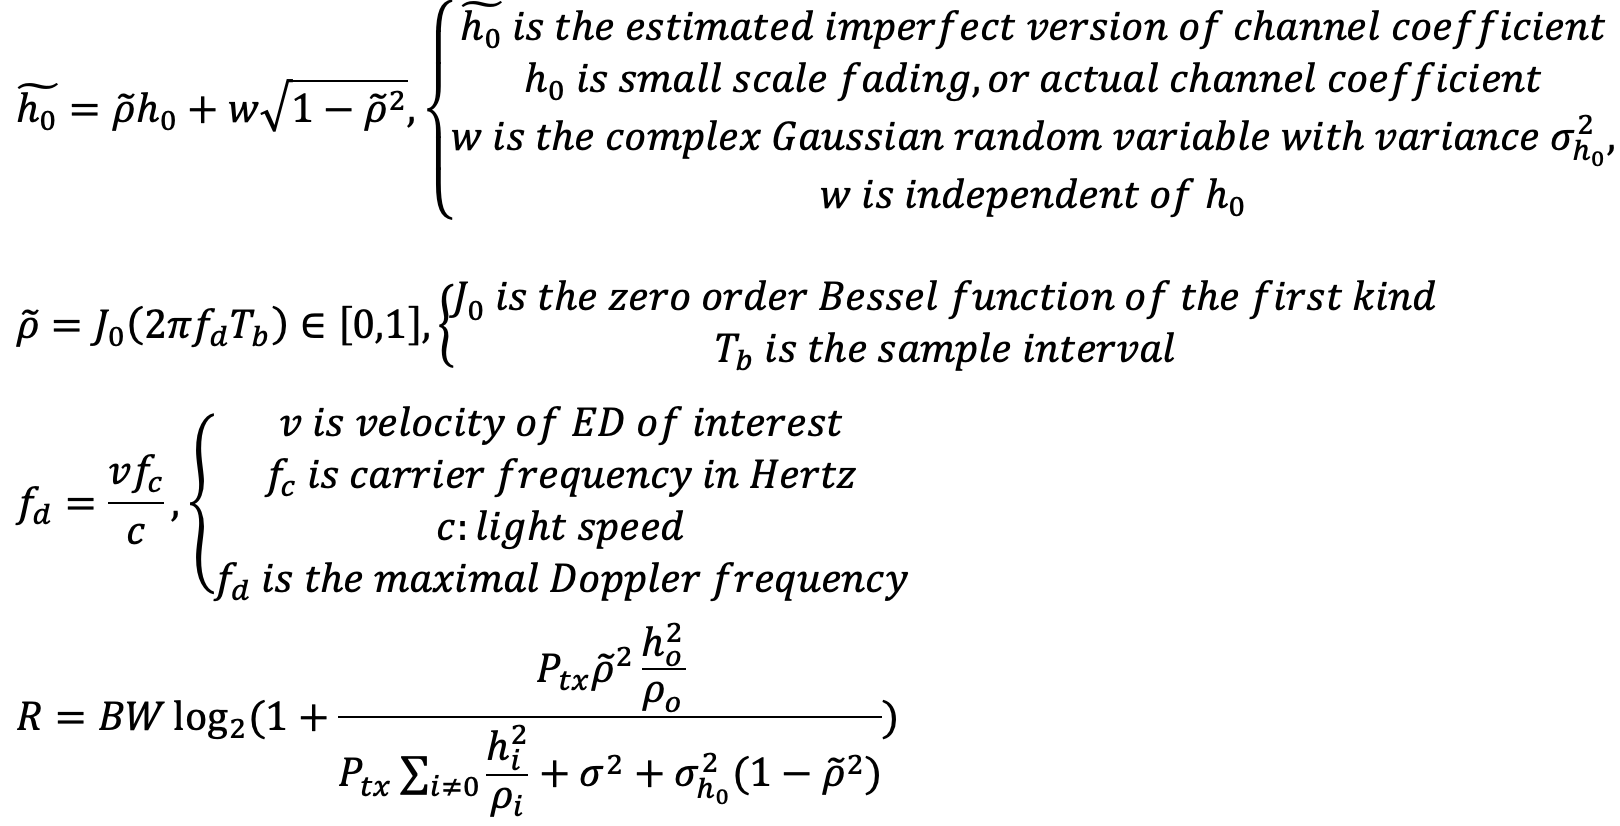

In [ ]:
class LoRadeployment(gym.Env):
    def __init__(self):

        #start of Q'part
        self.distance_to_base = [200*i for i in range(8)]        # in metre
        self.BW = [1000*i for i in (50,100,150,200,250,300,350,400,450,500)]    #BW in Hertz
        self.CR = 0.67      #[4/(4+o) for o in range(1,3)]
        self.SF = 9         #[i for i in range(8,10)]
        self.L_pac = 60     #[i*8 for i in (40,60,80)] #L_pac in bit
        self.T_in = 45*60   #[i*60 for i in (30,45,60)] #T_in in second

        # fix beta, Pcir, Pidle for a simplication
        self.beta = 2
        self.P_cir = 1.259
        self.P_idle = 0.398
        self.basestation = (0,35)
        self.f_c = 868e6
        self.NF = 6 #NF in dBm
        self.lambda_c_ = 10000/(np.pi*2000*2000)
        # end fixed part
        end_devices = [(i,0) for i in self.distance_to_base]

        self.test_end_devices = end_devices

        self.P_tx = [10**(i/100) for i in range(-400,500)]
        self.action_space_q = self.P_tx
        self.state_space_q = [(device_of_interest[0], _end_devices,B, self.CR, self.SF, self.L_pac, self.T_in) \
                              for device_of_interest in combinations(end_devices,1) \
                              for _end_devices in combinations(end_devices, 7 )
                              for B in self.BW ]
                              #for C in self.CR \
                              #for S in self.SF \
                              #for L in self.L_pac \
                              #for T in self.T_in ]

        # end of Q'part


    def _interference(self, P_tx, end_devices ):
        temp = 0
        for i in end_devices:
            r_i = np.linalg.norm(np.array(i) - np.array(self.basestation))
            rho_i = np.square(4*np.pi*self.f_c/3*10**8)*(r_i**self.beta)

            shape = random.randint(1, 30)
            h_i = nakagami.rvs(shape)

            temp += h_i*h_i/rho_i

        return P_tx*temp*10000
            

    def _energy_efficiency(self, interference, P_tx , state ):
        BW = state[2]
        L_pac = state[5]
        lambda_c = self.lambda_c_
        T_in = state[6]
        SF = state[4]
        CR = state[3]

        shape = random.randint(1, 30)
        h_0 = nakagami.rvs(shape) 
            
        r_0 = np.linalg.norm(np.array(state[0]) - np.array(self.basestation))
        #f_c is attribute of receiver, so it is fixed at __init__
        K_0 = np.square(4*np.pi*self.f_c/(3e8))
        rho_0 = K_0 * (r_0**self.beta)

        # print('rho_0 = ', rho_0)

        #new part
        J_0 = scipy.special.kn(0,1)
        v_device = 10  # in metre per second
        v_c = 3*10**8
        f_d = v_device*self.f_c/v_c
        T_d = 1/10**3
        rho_n = J_0*2*np.pi*f_d*T_d
        #
        
        R_bit = SF * BW * CR / 2**SF
        S = P_tx*h_0*h_0*h_0*h_0/rho_0
        noise = np.power(10,(-174 + self.NF + 10*np.log10(BW))/10)
        lambda_a = L_pac*lambda_c/(T_in*R_bit)
        P_con = lambda_a*(P_tx + self.P_cir) + (lambda_c - lambda_a)*self.P_idle
        R_perbit = np.log2(1 + S/(interference + noise + 1 - rho_n*rho_n ))
        PSE = lambda_a * BW * R_perbit
        EE = PSE/P_con
        # print('Interference = ', interference)
        # print('S = ', S)
        # print('noise = ', noise)
        # print('lambda_a = ', lambda_a)
        # print('PSE = ', PSE)
        # print('P_con = ', P_con)

        

        return EE, R_perbit
        
        
    def get_next_state_reward(self, state, action):
        result = {}
        result['Interference'] = self._interference(action, state[1])
        result['EE'], result['R_perbit'] = self._energy_efficiency(result['Interference'], action, state)
    
        # print(result)
        return result


    # call this method before we start an episode, every time
    def reset(self):
        #state = np.random.choice(self.state_space_q)
        state = random.choices(self.state_space_q, k=1)[0]
        print(state)
        return state

    
    
    # simulates the environment for a one-time step given the current state and the action
    def step(self, state, action):
        result = self.get_next_state_reward(state, action)
        state = random.choices(self.state_space_q, k=1)[0]
        reward = result['EE']
        R_perbit = result['R_perbit']
        return state, reward, R_perbit

In [ ]:
def choose_action(state, policy):
    prob_a = policy[state]
    action = np.random.choice(a=list(prob_a.keys()), 
                              p=list(prob_a.values()))
    return action

In [ ]:
def get_random_policy(states, actions):
    policy = {}
    n_a = len(actions)
    for s in states:
        policy[s] = {a: 1/n_a for a in actions}
    return policy

In [ ]:
def get_eps_greedy(actions, eps, a_best):
    prob_a = {}
    n_a = len(actions)
    for a in actions:
        if a == a_best:
            prob_a[a] = 1 - eps + eps/n_a
        else:
            prob_a[a] = eps/n_a
    return prob_a

In [ ]:
def q_learning(env, gamma, eps, alpha, n_iter):
    np.random.seed(0)
    states =  env.state_space_q
    actions = env.action_space_q    
    Q = {s: {a: 10 for a in actions} for s in states}
    policy = get_random_policy(states, actions)

    # Keeps track of useful statistics
    stats = plotting_edit.EpisodeStats(
        episode_lengths = np.zeros(n_iter),
        episode_rewards = np.zeros(n_iter)) 
    
    s = env.reset()
    for i in range(n_iter):
        if i % 1000 == 0:
            print("Iteration:", i)
        a_best = max(Q[s].items(), key=operator.itemgetter(1))[0]
        policy[s] = get_eps_greedy(actions, eps, a_best)
        a = choose_action(s, policy)
        s_next, reward, done, info = env.step(s, a)
        Q[s][a] += alpha * (reward + gamma * max(Q[s_next].values()) - Q[s][a])    
        
        #check whether an episode is done
        if done:
            s = env.reset()
        else:
            s = s_next

        #gather plotting statistics
        stats.episode_rewards[i] += reward
        stats.episode_lengths[i] = 1


    policy = {s: {max(policy[s].items(), key=operator.itemgetter(1))[0]: 1}
                 for s in states}

    return policy, Q, stats

In [ ]:
city = LoRadeployment()
policy, Q, stats = q_learning(city, gamma = 0.8, eps = 0.05, alpha = 0.1, n_iter = 5000)

((400, 0), ((0, 0), (400, 0), (600, 0), (800, 0), (1000, 0), (1200, 0), (1400, 0)), 450000, 0.67, 9, 60, 2700)
Iteration: 0
Iteration: 1000
Iteration: 2000
Iteration: 3000
Iteration: 4000


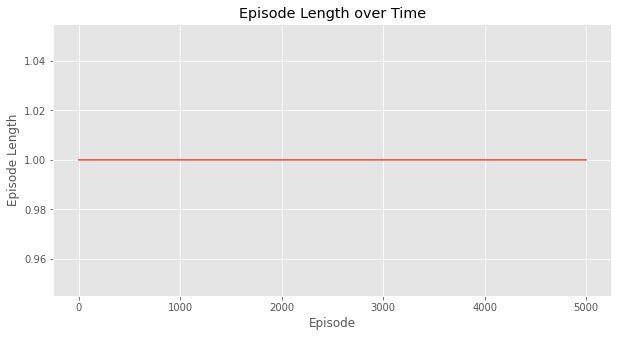

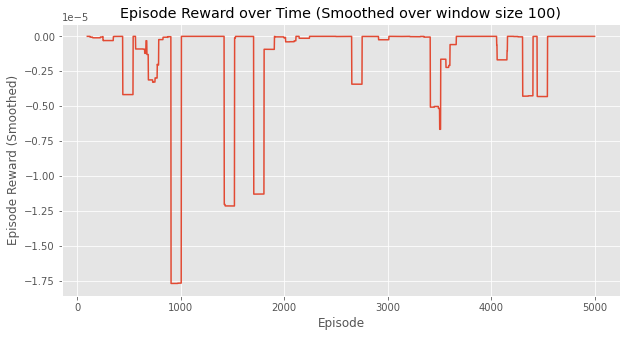

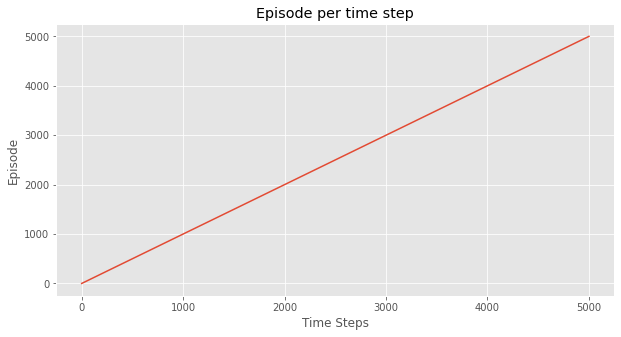

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [ ]:
plotting_edit.plot_episode_stats(stats)

#Draft part

In [ ]:
rstring2 = """
fun2 <- function(x,NSim,nn) {
    if (NSim == 1){
                    tam01 <- coords(x)
                    return(tam01)
                    } else {
                            nameempty <- character object of length NSim(500)
                            #Q: nameemty = character(500)
                            for (ii in 1:NSim){
                                                nameempty[ii] <- paste('S',ii,sep='')
                                                #Q: nameempty[1] = 'S 1', nameempty[500] = 'S 500'
                                                }
                            names(x) <- nameempty
                            #Q: Functions to get or set the names of an object.
                            tam03 <- paste('S',nn,sep='')
                            ##tam02 <- x$tam03
                            return(x[[nn]])
                            }
    
}
"""

In [ ]:
temp1 = 1
a = np.array([1,2,3])
temp1 += a
print(temp1)

[2 3 4]


In [ ]:
def draft(i):
    a = np.array([1,2,3])
    return a

result = [draft(i) for i in range(4)]
print(type(result))

<class 'list'>


In [ ]:

import numpy as np
P1=np.array([[0,901,901],[40,0,0]])
print(P1.shape)
pcov_each_trial = np.nanmean(P1, axis=0)
pcov_each_trial

(2, 3)


array([ 20. , 450.5, 450.5])

In [ ]:
import numpy.matlib
P1dBm = np.arange(-40, 50.1, 0.1)
print('P1 shape',P1dBm.shape)
p1sigma_remap = np.matlib.repmat(P1dBm, 40, 1)
print('remap shape',p1sigma_remap.shape)
radius_ED = P1
NoED = len(radius_ED)
NoED

P1 shape (901,)
remap shape (40, 901)


3

In [ ]:
import multiprocessing
num_cores = multiprocessing.cpu_count()
print(num_cores)

2


In [ ]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("val_index", help="Choose val_index", type=int)  # 1 2 3
args = parser.parse_args()

rutgon = args.val_index

usage: ipykernel_launcher.py [-h] val_index
ipykernel_launcher.py: error: argument val_index: invalid int value: '/root/.local/share/jupyter/runtime/kernel-d7b129b6-168d-40bc-91fc-6c69d8f829d7.json'


SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
a = np.random.randint(10,size=(2,3))
print('a=',a)
b = np.zeros((2,3))
print('b=',b)
c = b >= a
print('c=',c)
c= 1*c
print('new c=',c)

a= [[2 5 0]
 [9 2 1]]
b= [[0. 0. 0.]
 [0. 0. 0.]]
c= [[False False  True]
 [False False False]]
new c= [[0 0 1]
 [0 0 0]]


In [ ]:
distance_to_base = [i for i in range(3)]
end_devices = [i for i in distance_to_base]
x = combinations(end_devices, 2)
for i in x:
    print(i)

(0, 1)
(0, 2)
(1, 2)


In [ ]:
type(5e6)

float

In [ ]:
import numpy as np
import gym
import operator
from itertools import combinations

class FoodTruck_refine(gym.Env):
    def __init__(self):

        #start of Q'part
        self.distance_to_base = [i for i in range(50)]
        self.BW = [i for i in range(1,500)]
        self.CR = [4/(4+o) for o in range(1,4)]
        self.SF = [i for i in range(7,12)]
        self.L_pac = [i for i in range(1,120)]
        self.T_in = [i for i in range(1,90)]
        # afixed info
            # self.cardinality_state_space_q = 
        # fix beta, Pcir, Pidle for a simplication
        self.beta = 3.6
        self.P_cir = 1
        self.P_idle = -4
        self.basestation = (0,5)
        self.f_c = 868
        self.NF = 6
        self.lambda_c_ = 10/(np.pi*50*50)
        # end fixed part
        end_devices = [(i,0) for i in self.distance_to_base]
        self.P_tx = [i for i in range(50)]
        self.action_space_q = self.P_tx
        self.state_space_q = [(device_of_interest, _end_devices, B, C, S, L, T) \
                              for device_of_interest in combinations(end_devices,1) \
                              for _end_devices in combinations(end_devices, 10 )
                              for B in self.BW \
                              for C in self.CR \
                              for S in self.SF \
                              for L in self.L_pac \
                              for T in self.T_in \
                              # for index in range(len()): co the danh index cho state duoc khong?
                              ]

        # end of Q'part

    def _interference(self, P_tx, end_devices ):
        temp = 0
        for i in end_devices:
            r_i = np.linalg.norm(i - self.basestation)
            rho_i = np.square(4*np.pi*self.f_c/3*10**8)*r_i**self.beta
            h_i = np.random.normal(1,1)
            temp += h_i*h_i/rho_i

        return P_tx*temp
            

    def _energy_efficiency(self, interference, P_tx , state ):
        BW = state[2]
        L_pac = state[5]
        lambda_c = self.lambda_c_
        T_in = state[6]
        SF = state[4]
        CR = state[3]
        h_0 = h_i = np.random.normal(1,1)
        r_0 = np.linalg.norm(state[0] - self.basestation)
        #f_c is attribute of receiver, so it is fixed at __init__
        K_0 = np.square(4*np.pi*self.f_c/(3*10**8))
        rho_0 = K_0 * r_0**self.beta
        R_bit = SF * BW * CR / 2**SF
        S = P_tx*h_0*h_0/rho_0
        noise = np.power(10,(-174 + self.NF + 10*np.log10(BW))/10)
        lambda_a = L_pac*lambda_c/(T_in*R_bit)
        P_con = lambda_a*(P_tx + self.P_cir) + (lambda_c - lambda_a)*self.P_idle
        PSE = lambda_a * BW * np.log2(1 + S/(interference + noise))
        EE = PSE/P_con
        return EE
        
        
    def get_next_state_reward(self, state, action):
        # start Q's part
        result = {}
        result['Interference'] = self._interference(action, state[1])
        result['reward'] = self._energy_efficiency(result['Interference'], action, state)
        # end Q's part
        # considering the index
        return result


    def get_transition_prob(self, state, action):
        next_s_r_prob = {}
        for ix, demand in enumerate(self.v_demand):
            result = self.get_next_state_reward(state, action, demand)
            next_s = (result['next_day'], result['next_inventory'])
            reward = result['reward']
            prob = self.p_demand[ix]
            if (next_s, reward) not in next_s_r_prob:
                next_s_r_prob[next_s, reward] = prob
            else:
                next_s_r_prob[next_s, reward] += prob
        return next_s_r_prob

    # call this method before we start an episode, every time
    def reset(self):
        state = np.random.choice(a = self.state_space_q)
        return state
    
    def is_terminal(self, state):
        day, inventory = state
        if day == "Weekend":
            return True
        else:
            return False
    
    # simulates the environment for a one-time step given the current state and the action
    def step(self, state, action):
        result = self.get_next_state_reward(state, action)
        state = np.random.choice(a = self.state_space_q)
        reward = result['reward']
        return state, reward

def choose_action(state, policy):
    prob_a = policy[state]
    action = np.random.choice(a=list(prob_a.keys()), 
                              p=list(prob_a.values()))
    return action

def get_random_policy(states, actions):
    policy = {}
    n_a = len(actions)
    for s in states:
        policy[s] = {a: 1/n_a for a in actions}
    return policy

def get_eps_greedy(actions, eps, a_best):
    prob_a = {}
    n_a = len(actions)
    for a in actions:
        if a == a_best:
            prob_a[a] = 1 - eps + eps/n_a
        else:
            prob_a[a] = eps/n_a
    return prob_a


def q_learning(env, gamma, eps, alpha, n_iter):
    np.random.seed(0)
    states =  env.state_space
    actions = env.action_space
    Q = {s: {a: 0 for a in actions} for s in states}
    policy = get_random_policy(states, actions)
    s = env.reset()
    for i in range(n_iter):
        if i % 1000 == 0:
            print("Iteration:", i)
        a_best = max(Q[s].items(), key=operator.itemgetter(1))[0]
        policy[s] = get_eps_greedy(actions, eps, a_best)
        a = choose_action(s, policy)
        s_next, reward = env.step(s, a)
        Q[s][a] += alpha * (reward + gamma * max(Q[s_next].values()) - Q[s][a])    
        s = s_next
    policy = {s: {max(policy[s].items(), key=operator.itemgetter(1))[0]: 1}
                 for s in states}
    return policy, Q


foodtruck = FoodTruck_refine()
policy, Q = q_learning(foodtruck, 0.9, 0.1, 0.01, 10000)